# NN Algorithm for dazzled camera identification

In [19]:
import numpy as np 
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

In [31]:
def Max(data_array):
    max = np.max(data_array, axis=1)
    return max

def Amp(data_array):
    amp = np.sum(data_array, axis=1)
    return amp

def Ratio(data_array):
    max = np.max(data_array, axis=1)
    mean = np.mean(data_array, axis=1)
    ratio = 1 - mean/max
    ratio[np.isnan(ratio)] = 1
    return ratio

## Import data and MC truth

In [32]:
data_path = './dazzled_cameras_dataset'

# Load Data  
with open(data_path+'/simulation_11.npy', 'rb') as b:    #'+str(sim_num)+'
    data_in_1 = np.load(b)
with open(data_path+'/simulation_22.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_2 = np.load(c)
with open(data_path+'/simulation_33.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_3 = np.load(c)
    
# Load MC Truth
with open(data_path+'/inner_ph_11.npy', 'rb') as f:      #'+str(sim_num)+'
    ph_in_1 = np.load(f)
with open(data_path+'/inner_ph_22.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_2 = np.load(g)
with open(data_path+'/inner_ph_33.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_3 = np.load(g) 

## Preprocessing

### Concatenate multiple datasets

In [33]:
###### fixed parameters ###########
#n_cam_in_grain_0 = 54
n_cam_in_grain_1 = 58
n_cam_in_grain_2 = 60
n_cam_in_grain_3 = 60
cam_side_length = 32
###################################

inner_ph_in_1 = ph_in_1[:,0].reshape(n_cam_in_grain_1, -1)
inner_ph_in_2 = ph_in_2[:,0].reshape(n_cam_in_grain_2, -1)
inner_ph_in_3 = ph_in_3[:,0].reshape(n_cam_in_grain_3, -1)

inner_ratio_11 = ((ph_in_1[:,0])/(ph_in_1[:,1]-(ph_in_1[:,0]))).reshape(n_cam_in_grain_1, -1)
inner_ratio_22 = ((ph_in_2[:,0])/(ph_in_2[:,1]-(ph_in_2[:,0]))).reshape(n_cam_in_grain_2, -1)
inner_ratio_33 = ((ph_in_3[:,0])/(ph_in_3[:,1]-(ph_in_3[:,0]))).reshape(n_cam_in_grain_3, -1)
inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_grain_2, -1)
inner_ratio_3 = (ph_in_3[:,0]/ph_in_3[:,1]).reshape(n_cam_in_grain_3, -1)

data_in = np.concatenate((data_in_1.reshape(-1, cam_side_length**2), data_in_2.reshape(-1, cam_side_length**2), data_in_3.reshape(-1, cam_side_length**2))) #new_data_0, 
inner_ph_in = np.concatenate((np.ravel(inner_ph_in_1, order='F'), np.ravel(inner_ph_in_2, order='F'), np.ravel(inner_ph_in_3, order='F')))
inner_ratio = np.concatenate((np.ravel(inner_ratio_11, order='F'), np.ravel(inner_ratio_22, order='F'), np.ravel(inner_ratio_33, order='F')))

inner_ratio[np.isnan(inner_ratio)] = 0

# INCLUDE PIXEL SATURATION
data_in[data_in > 1000] = 1000


C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\987302853.py:13: RuntimeWarning: invalid value encountered in divide
  inner_ratio_11 = ((ph_in_1[:,0])/(ph_in_1[:,1]-(ph_in_1[:,0]))).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\987302853.py:14: RuntimeWarning: invalid value encountered in divide
  inner_ratio_22 = ((ph_in_2[:,0])/(ph_in_2[:,1]-(ph_in_2[:,0]))).reshape(n_cam_in_grain_2, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\987302853.py:15: RuntimeWarning: invalid value encountered in divide
  inner_ratio_33 = ((ph_in_3[:,0])/(ph_in_3[:,1]-(ph_in_3[:,0]))).reshape(n_cam_in_grain_3, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\987302853.py:16: RuntimeWarning: invalid value encountered in divide
  inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\987302853.py:17: RuntimeWarning: invalid value encountered in divide
  inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_

### Data labelling

In [34]:
###### parameters #################
ph_threshold = 50                 #
ratio_threshold = 0.1            #
###################################

label = np.zeros(inner_ph_in.shape[0])

for i in np.where( (inner_ratio > ratio_threshold) & (inner_ph_in > ph_threshold) )[0]:
    label[i] = 1
    
n_blind = label[label==1].shape[0]
n_not_blind = label[label==0].shape[0]
print('labelled-blind cameras :', n_blind)

labelled-blind cameras : 929


### Testing different parameters to label data

#### Threshold on the number of inner photons per camera 

C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\2903027117.py:12: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


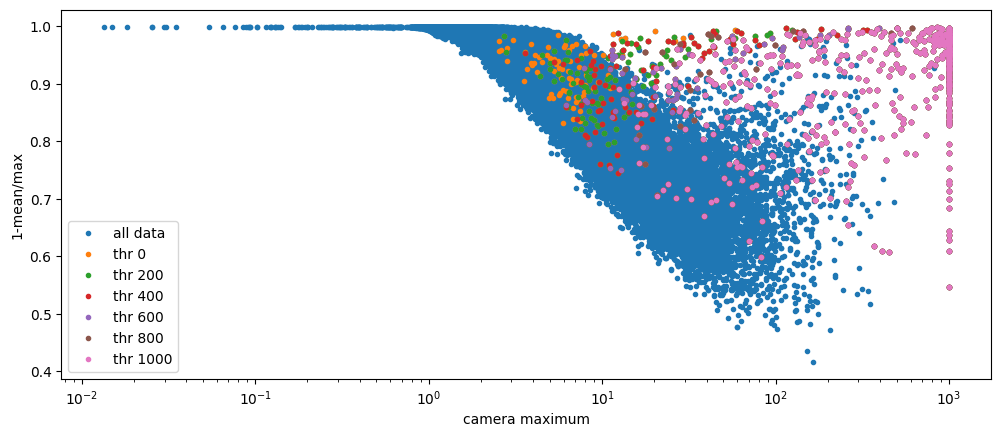

In [35]:
fig = plt.figure()

plt.plot(Max(data_in),Ratio(data_in), '.', label='all data')

for thr in range(0, 1200, 200):
    lab = np.zeros(inner_ph_in.shape[0])
    for i in np.where( (inner_ratio > ratio_threshold) & (inner_ph_in > thr) )[0]:
        lab[i] = 1
    plt.plot(Max(data_in)[lab == 1], Ratio(data_in)[lab == 1], '.', label='thr '+str(thr))
    
plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()
fig.set_figwidth(12)

#### Threshold on ratio

C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\3249598680.py:7: RuntimeWarning: invalid value encountered in divide
  _ratio = 1 - _mean/_max


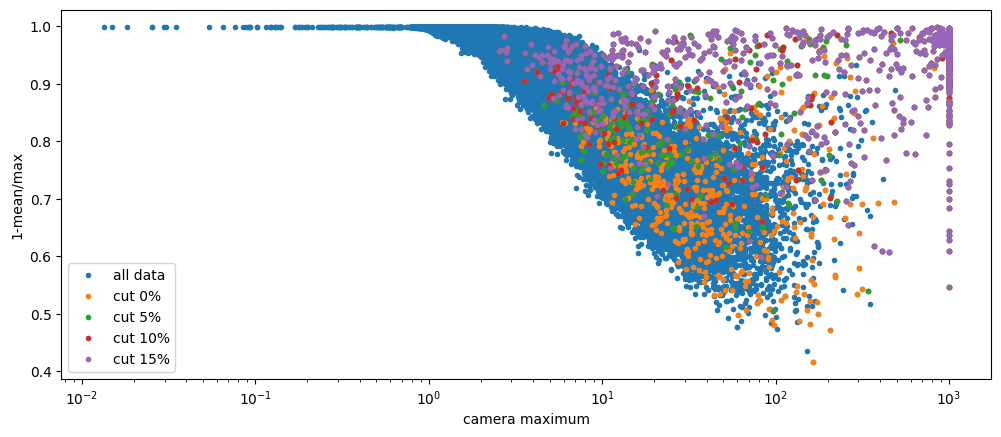

In [36]:
fig = plt.figure()

plt.plot(Max(data_in),  Ratio(data_in), '.', label='all data')
thr = 50
for cut in range(0, 20, 5):
    lab = np.zeros(inner_ph_in.shape[0])
    for i in np.where( (inner_ratio > (cut/100)) & (inner_ph_in > thr))[0]:
        lab[i] = 1
    plt.plot(Max(data_in)[lab == 1], Ratio(data_in)[lab == 1], '.', label='cut '+str(cut)+'%')
    
plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()
fig.set_figwidth(12)

### Split into test and training sets

In [37]:
sep = int(data_in.shape[0] * 0.8)

train_data, test_data = data_in[:sep], data_in[sep:]
train_label, test_label = label[:sep], label[sep:]

print(train_data.shape)
print(train_label.shape)

(142400, 1024)
(142400,)


### Data augmentation for dazzled dataset

In [38]:
train_blind = train_data[np.where(train_label==1)]
train_not_blind = train_data[np.where(train_label==0)]

rdm = np.random.default_rng(12345)
rdm_x = rdm.integers(low=0, high=31, size=int(0.3*n_not_blind))
rdm_y = rdm.integers(low=0, high=31, size=int(0.3*n_not_blind))
artificial_train_blind = np.repeat(train_blind, int(0.3*n_not_blind/train_blind.shape[0]), axis=0).reshape(-1, cam_side_length, cam_side_length, 1)
for r in range(artificial_train_blind.shape[0]) :
    artificial_train_blind[r] = np.roll(artificial_train_blind[r], (rdm_x[r] ,rdm_y[r]), axis=(2,1))
    
artificial_train_label = np.ones(artificial_train_blind.shape[0])

print('blind cameras - total data ratio:',(len(artificial_train_label) + len(train_label[train_label == 1]))/len(train_label))

train_data = np.append(train_data, artificial_train_blind.reshape(-1, cam_side_length**2),axis=0)
train_label = np.append(train_label, artificial_train_label)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_arr = np.column_stack((Ratio(train_data), Max(train_data)))
test_arr = np.column_stack((Ratio(test_data), Max(test_data)))

blind cameras - total data ratio: 0.374873595505618


C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\2903027117.py:12: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


### Plot augmented data

C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\2903027117.py:12: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


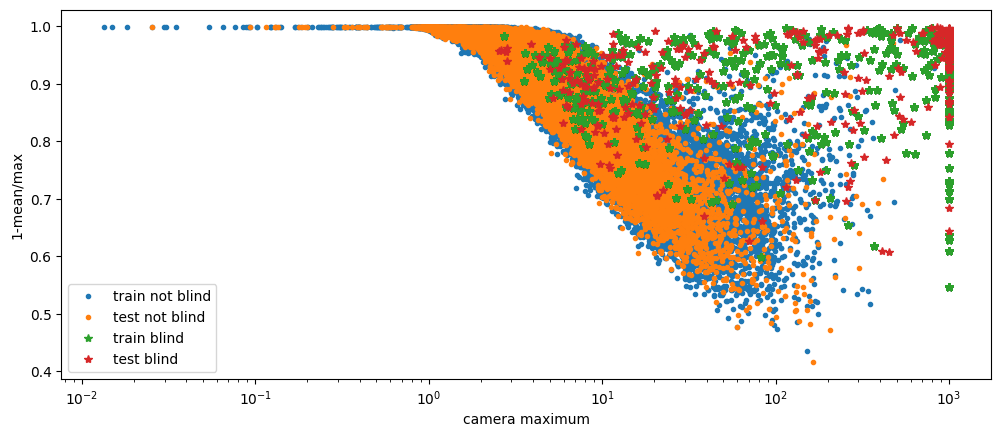

In [40]:
plt.figure().set_figwidth(12)
plt.plot(Max(train_data)[train_label == 0], Ratio(train_data)[train_label == 0], '.', label='train not blind')
plt.plot(Max(test_data)[test_label == 0], Ratio(test_data)[test_label == 0], '.', label='test not blind')
plt.plot(Max(train_data)[train_label == 1], Ratio(train_data)[train_label == 1], '*', label='train blind')
plt.plot(Max(test_data)[test_label == 1], Ratio(test_data)[test_label == 1], '*', label='test blind')

plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()

## Build the model

### Model 1 - SGD

In [41]:
sgd_clf = SGDClassifier(max_iter=2000, tol=1e-3, random_state=42)
sgd_clf.fit(train_arr, train_label)

sgd_score = sgd_clf.score(test_arr, test_label)
cross_score = cross_val_score(sgd_clf, test_arr, test_label, cv=2, scoring="precision")
pred_label = cross_val_predict(sgd_clf, test_arr, test_label, cv=2)

cm = confusion_matrix(pred_label, test_label)
prec = precision_score(pred_label, test_label)
reca = recall_score(pred_label, test_label)
f1 = f1_score(pred_label, test_label)
    
print('confusion matrix :')
print(cm)
print('precision :', prec)
print('recall :', reca)
print('f1 score :', f1)

confusion matrix :
[[35206   168]
 [   39   187]]
precision : 0.5267605633802817
recall : 0.827433628318584
f1 score : 0.6437177280550773


### Model 2 - KFold

In [42]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
LR = LogisticRegression() #LinearRegression()

cross_score_LR = cross_val_score(LR, test_arr, test_label, cv=kfold, scoring='neg_mean_absolute_error')
pred_label_LR = cross_val_predict(LR, test_arr, test_label, cv=kfold)

cm_LR = confusion_matrix(pred_label_LR, test_label)
prec_LR = precision_score(pred_label_LR, test_label)
reca_LR = recall_score(pred_label_LR, test_label)
f1_LR = f1_score(pred_label_LR, test_label)
    
print('kfold :', kfold)
print('confusion matrix :')
print(cm_LR)
print('precision :', prec_LR)
print('recall :', reca_LR)
print('f1 score :', f1_LR)

kfold : KFold(n_splits=10, random_state=7, shuffle=True)
confusion matrix :
[[35228   181]
 [   17   174]]
precision : 0.49014084507042255
recall : 0.9109947643979057
f1 score : 0.6373626373626373


## Prediction vs MC truth visualization

### Model 1

C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\2903027117.py:12: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


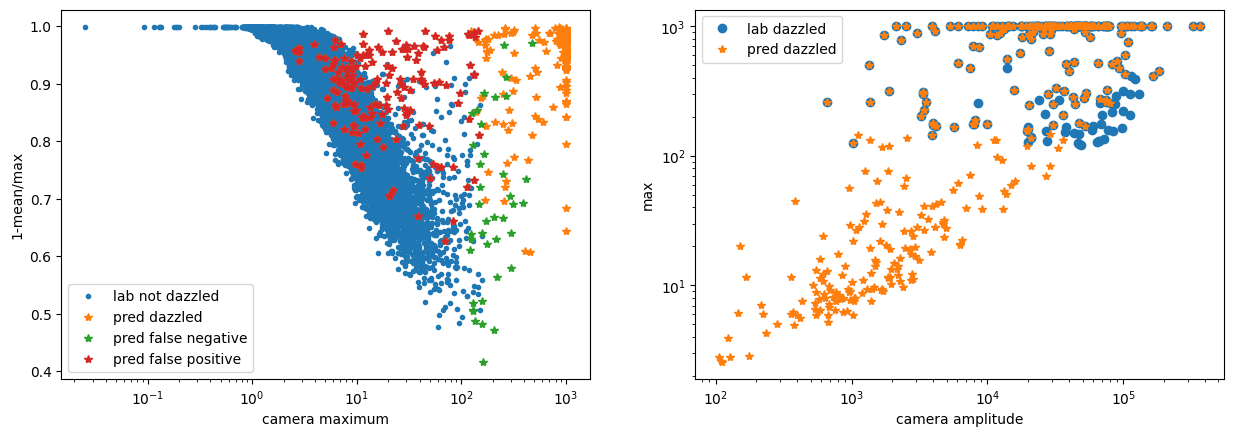

In [43]:
test_d = data_in[sep:]

lab_bl = test_d[np.where(pred_label==1)]
lab_not_bl = test_d[np.where(pred_label==0)]
pred_bl = test_d[np.where(test_label==1)]
pred_not_bl = test_d[np.where(test_label==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_label==1), np.where(test_label==0))]
pred_fp = test_d[np.intersect1d(np.where(pred_label==0), np.where(test_label==1))]

fig, ax = plt.subplots(1,2)
ax[0].plot(Max(lab_not_bl), Ratio(lab_not_bl), '.', label='lab not dazzled')
ax[0].plot(Max(pred_bl), Ratio(pred_bl), '*', label='pred dazzled')
ax[0].plot(Max(pred_fn), Ratio(pred_fn), '*', label='pred false negative')
ax[0].plot(Max(pred_fp), Ratio(pred_fp), '*', label='pred false positive')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(Amp(lab_bl), Max(lab_bl), 'o', label='lab dazzled')
ax[1].plot(Amp(pred_bl), Max(pred_bl), '*', label='pred dazzled')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].set_ylabel('max')
ax[1].legend()

fig.set_figwidth(15)

### Model 2

C:\Users\Pc\AppData\Local\Temp\ipykernel_25888\2903027117.py:12: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


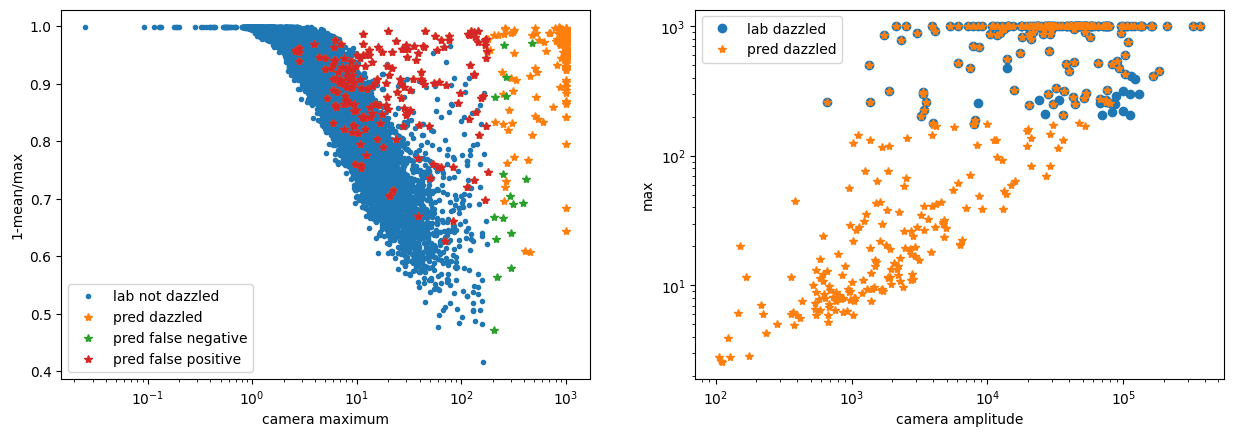

In [44]:
test_d = data_in[sep:]

lab_bl = test_d[np.where(pred_label_LR==1)]
lab_not_bl = test_d[np.where(pred_label_LR==0)]
pred_bl = test_d[np.where(test_label==1)]
pred_not_bl = test_d[np.where(test_label==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_label_LR==1), np.where(test_label==0))]
pred_fp = test_d[np.intersect1d(np.where(pred_label_LR==0), np.where(test_label==1))]

fig, ax = plt.subplots(1,2)
ax[0].plot(Max(lab_not_bl), Ratio(lab_not_bl), '.', label='lab not dazzled')
ax[0].plot(Max(pred_bl), Ratio(pred_bl), '*', label='pred dazzled')
ax[0].plot(Max(pred_fn), Ratio(pred_fn), '*', label='pred false negative')
ax[0].plot(Max(pred_fp), Ratio(pred_fp), '*', label='pred false positive')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(Amp(lab_bl), Max(lab_bl), 'o', label='lab dazzled')
ax[1].plot(Amp(pred_bl), Max(pred_bl), '*', label='pred dazzled')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].set_ylabel('max')
ax[1].legend()

fig.set_figwidth(15)